In [108]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import savgol_filter

# mapping '/' to __truediv__()
from __future__ import division 

from sklearn.metrics import mean_absolute_error
# possible alternative to above:
# tf.metrics.MeanAbsoluteError()

# helper code
from WindowGenerator import WindowGenerator
from Baseline import Baseline

mpl.rcParams['figure.figsize'] = (12, 3)
mpl.rcParams['axes.grid'] = False

VERBOSE = True
MAX_EPOCHS = 30
INPUT_WIDTH = 3
LABEL_WIDTH = 1
SHIFT = 14
WINDOW_SIZE = INPUT_WIDTH + SHIFT

if VERBOSE:
    print('Setup Complete')

Setup Complete


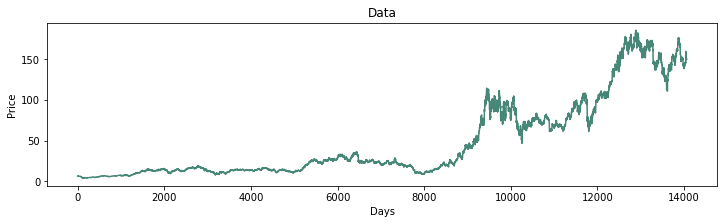

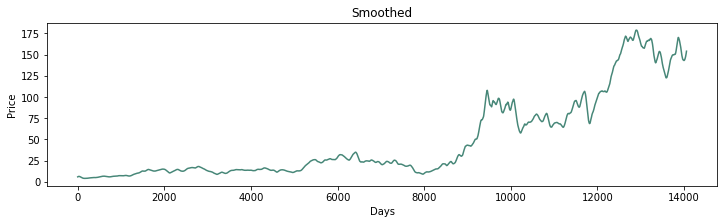

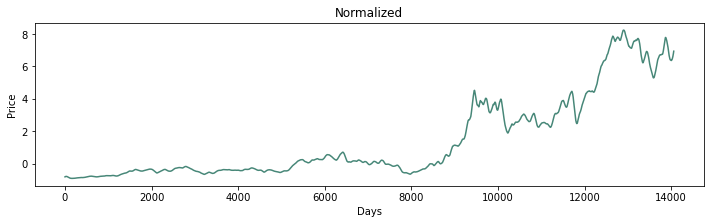

0       1962-01-02
1       1962-01-03
2       1962-01-04
3       1962-01-05
4       1962-01-08
           ...    
14054   2017-11-06
14055   2017-11-07
14056   2017-11-08
14057   2017-11-09
14058   2017-11-10
Name: ds, Length: 14059, dtype: datetime64[ns]
total samples = 14059
----------------------------------------
train_df samples = 9841
val_df samples = 2812
test_df samples = 1406
----------------------------------------
train + val + test = 14059


In [109]:
df = pd.read_csv('data/ibm_edit.csv')

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

plt.title('Data')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

plt.title('Smoothed')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# split
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# normalize
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

plt.title('Normalized')
df_std = (df - train_mean) / train_std
y = df_std['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

if VERBOSE:
    print( date_time )
    print( "total samples = {0:d}".format( n ) )
    print( "----------------------------------------" )
    print( "train_df samples = {0:d}".format( len( train_df ) ) )
    print( "val_df samples = {0:d}".format( len( val_df ) ) )
    print( "test_df samples = {0:d}".format( len( test_df ) ) )
    print( "----------------------------------------" )
    print( "train + val + test = {0:d}".format( len( train_df ) + len( val_df ) + len( test_df ) ) )

                y
0        5.797492
1        5.838859
2        5.878398
3        5.916131
4        5.952081
...           ...
14054  152.603785
14055  152.962478
14056  153.328342
14057  153.701404
14058  154.081695

[14059 rows x 1 columns]
years: 56.01195219123506


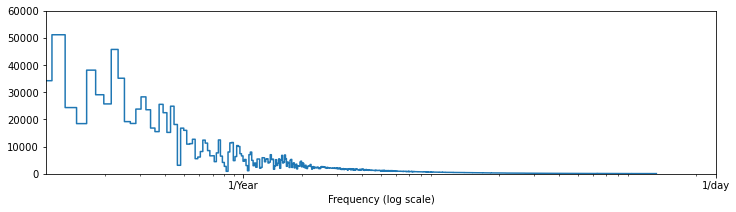

In [136]:
# frequency
print(df)
fft = tf.signal.rfft(df['y'])
f_per_dataset = np.arange(0, len(fft)) #????

num_samples_days = len(df['y'])
busi_days_per_year = 251
years_per_dataset = num_samples_days/(busi_days_per_year)
print(f'years: {years_per_dataset}')

f_per_year = f_per_dataset/years_per_dataset #????
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 60000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 251], labels=['1/Year', '1/day']) #????
_ = plt.xlabel('Frequency (log scale)')

In [102]:
conv_window = WindowGenerator( train_df=train_df, test_df=test_df, val_df=val_df,
                               input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT, label_columns=['y'])
if VERBOSE:
    print( conv_window )

Total window size: 17
Input indices: [0 1 2]
Label indices: [16]
Label column name(s): ['y']


In [103]:
def compile_and_fit(model, window, patience=10):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    
    return history

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(INPUT_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])

test mean absolute error = 0.246


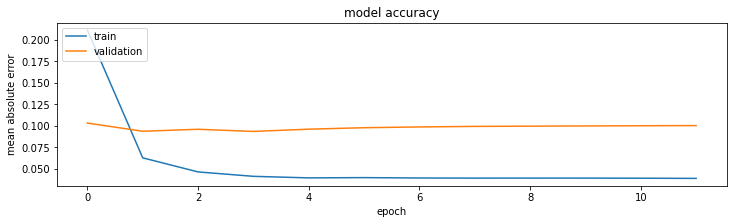

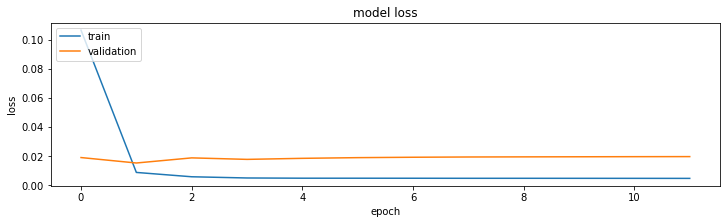

In [104]:
# train and eval model
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()

# use model on test
test_iterator = iter(conv_window.test)
y_p = []
y = []
for inputs, labels in test_iterator:
    predictions = conv_model( inputs )
    for i in range( predictions.shape[0] ):
        y_p.append( predictions[i][0,:][0].numpy() )
        y.append( labels[i][0,:][0] )

y_p = np.array( y_p )
y = np.array( y )
mae = mean_absolute_error( y_p, y )
print( "test mean absolute error = {0:0.3f}".format( mae ) )

plt.title('model accuracy')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

test mean absolute error = 0.246


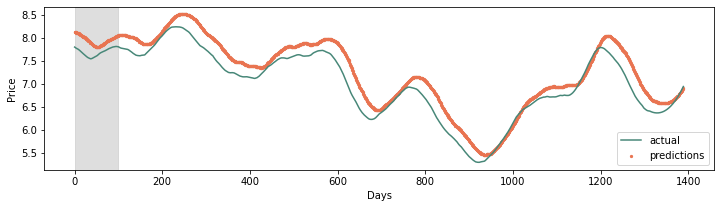

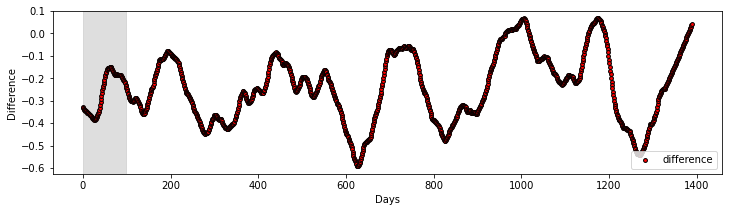

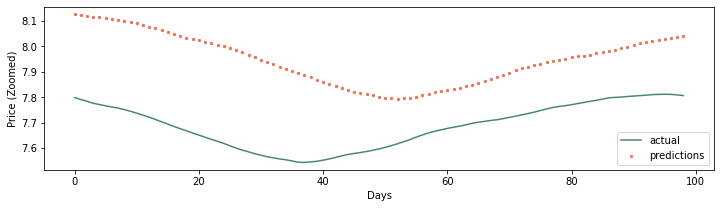

In [105]:
print( "test mean absolute error = {0:0.3f}".format( mae ) )

x = np.arange( 0, len(y), 1 )
zoom_pwr = 14
zoom_idx = int(np.floor(len(y)/zoom_pwr))
x_zoom = np.arange(0, zoom_idx, 1)
y_zoom = y[: zoom_idx]
y_p_zoom = y_p[: zoom_idx]
shd_alpha = 0.6

plt.ylabel('Price')
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
p1, = plt.plot( x, y, label='test', color='#478778' )
p2 = plt.scatter( x, y_p, edgecolors='#E97451', color='#E97451', s=5 )
plt.legend(handles=[p1, p2], labels=['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.ylabel('Difference')
p1 = plt.scatter( x, ( y-y_p ), edgecolors='black', color='red', s=15 )
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
plt.legend(handles=[p1], labels=['difference'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.ylabel('Price (Zoomed)')
plt.plot( x_zoom, y_zoom, label='test', color='#478778' )
plt.scatter( x_zoom, y_p_zoom, edgecolors='#E97451', color='#E97451', s=5)
plt.legend(['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

## Real world result
Make a single prediction based on the history of a different stock.

               ds        y
14000  2017-08-22  24.3675
14001  2017-08-23  24.2055
14002  2017-08-24  24.1785
14003  2017-08-25  24.2330
14004  2017-08-28  24.2655
14005  2017-08-29  24.1290
14006  2017-08-30  24.0795
14007  2017-08-31  24.2480
14008  2017-09-01  24.6490
14009  2017-09-05  24.5700
14010  2017-09-06  24.6730
14011  2017-09-07  23.9505
14012  2017-09-08  23.5550
14013  2017-09-11  23.5200
14014  2017-09-12  23.5740
14015  2017-09-13  23.8120
14016  2017-09-14  23.8665
Prediction: 25.12


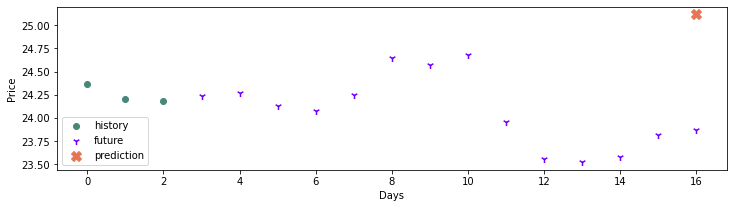

In [106]:
# specify pathname
pathname = 'data/ge_edit.csv'
df = pd.read_csv(pathname)
df_len = len(df['y'])

start_idx = 14000
start_idx = min(start_idx, len(df['y'])-WINDOW_SIZE)
start_idx = max(start_idx, 0)
# drop beginning
df = df.drop(index=range(0, start_idx))
# drop end
df = df.drop(index=range(start_idx+WINDOW_SIZE, df_len))

print(df)

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp_s = date_time.map(datetime.datetime.timestamp)

# divide dataframe
input_df = df[:INPUT_WIDTH]
future_df = df[INPUT_WIDTH:] # pretend we don't know these future values

# make prediction
y_p = []
conv_window = WindowGenerator(train_df=df, test_df=df, val_df=df,
                              input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                              shift=SHIFT, label_columns=['y'])
test_iterator = iter(conv_window.test)
for inputs, labels in test_iterator:
    predictions = conv_model( inputs )
    for i in range( predictions.shape[0] ):
        y_p.append( predictions[i][0,:][0].numpy() )

# history
y = input_df.to_numpy()
x = np.arange(0, len(y), 1)
# future
y_f = future_df.to_numpy()
x_f = np.arange(len(y), len(y) + len(y_f), 1)
# prediction
y_p = np.array( y_p )
x_p = WINDOW_SIZE-1

if VERBOSE:
    y_p_format = "{:.2f}".format(y_p[0])
    print(f"Prediction: {y_p_format}")

# plot
plt.ylabel('Price')
plt.scatter(x, y, edgecolors='#478778', color='#478778')
# plt.plot(x, y, color='#478778')
plt.scatter(x_f, y_f, edgecolors='#6F00FF', color='#6F00FF', s=50, zorder=0, marker='1')
# plt.plot(x_f, y_f, color='#6F00FF')
plt.scatter(x_p, y_p, edgecolors='#E97451', color='#E97451', s=100, marker='X')
plt.legend(['history', 'future', 'prediction'], loc='lower left')
plt.xlabel('Days')
plt.show()